In [1]:
#!pip install openpyxl


In [2]:
#!pip install torch
import warnings
warnings.simplefilter(action='ignore')

In [3]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 32.5 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import torch
import transformers
import pandas as pd
from sklearn import preprocessing # For Label encoding
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import re
import itertools
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [5]:
import pandas as pd

## BERT

In [6]:
#!pip install transformers
#!pip install keras
#!pip install tensorflow

In [7]:
# Setting up GPU for Bert
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [8]:
from keras.preprocessing.sequence import pad_sequences

In [9]:
bert_df=pd.read_excel('/content/Patent_Top10_final_DF.xlsx')
bert_df.head()

,assignee_id,assignee,cited_assignee_id,cited_assignee,citations,Cited_patent_id,Cited_patent_type,Cited_patent_publish_date,Cited_patent_title
0,cae80f13-a805-43cf-bb89-b23d9b307828,U.S. Philips Corporation,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f,The University of North Carolina at Chapel Hill,3,10023831,utility,2018-07-17,Gas delivery devices and associated systems an...
1,04241157-5123-4d4d-ac69-7355fb596dc2,BAYER PHARMA AKTIENGESELLSCHAFT,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f,The University of North Carolina at Chapel Hill,2,10023831,utility,2018-07-17,Gas delivery devices and associated systems an...
2,57babb0d-1a2a-4b3c-9373-03219cdb615b,Canon Kabushiki Kaisha,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f,The University of North Carolina at Chapel Hill,1,10023831,utility,2018-07-17,Gas delivery devices and associated systems an...
3,6476d2b8-102b-44e2-ab5e-9cca098c737c,SIEMENS AKTIENGESELLSCHAFT,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f,The University of North Carolina at Chapel Hill,4,10023831,utility,2018-07-17,Gas delivery devices and associated systems an...
4,526f4809-fcbd-43b7-804a-431f687fdc43,GENERAL ELECTRIC COMPANY,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f,The University of North Carolina at Chapel Hill,5,10023831,utility,2018-07-17,Gas delivery devices and associated systems an...


In [10]:
bert_df["features"] = bert_df["cited_assignee_id"].astype(str)+' ' + bert_df["cited_assignee"]+' '+ bert_df["citations"].astype(str)+' '+bert_df["Cited_patent_id"].astype(str)+' '+bert_df["Cited_patent_type"].astype(str)+' '+bert_df["Cited_patent_publish_date"].astype(str)+' '+bert_df["Cited_patent_title"].astype(str)

In [11]:
bert_df=bert_df[['features','assignee']]
bert_df.head()

,features,assignee
0,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f The Unive...,U.S. Philips Corporation
1,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f The Unive...,BAYER PHARMA AKTIENGESELLSCHAFT
2,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f The Unive...,Canon Kabushiki Kaisha
3,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f The Unive...,SIEMENS AKTIENGESELLSCHAFT
4,5041bc4a-1e8b-4d93-8fa9-a563a2a9387f The Unive...,GENERAL ELECTRIC COMPANY


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X = bert_df[['features']]
y = bert_df[['assignee']]
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)
print(sss)
for train_index, test_index in sss.split(X, y):
     xtrain, xtest = X.iloc[train_index], X.iloc[test_index]
     ytrain, ytest = y.iloc[train_index], y.iloc[test_index]


StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)


Plotting Word counts in feature for Training Data


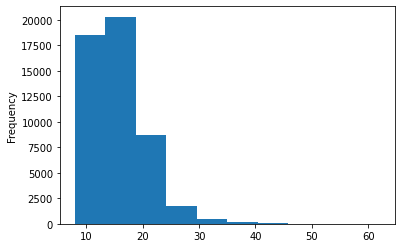

In [13]:
print("Plotting Word counts in feature for Training Data")
#We can see that most number of words are below 400 and peeks at 300
xtrain.features.apply(lambda x: len(x.split())).plot(kind='hist')

Plotting Word counts in feature for Training Data


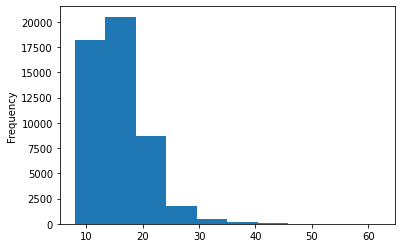

In [14]:
print("Plotting Word counts in feature for Training Data")
#We can see that most number of words are below 400 and peeks at 300
xtest.features.apply(lambda x: len(x.split())).plot(kind='hist')

In [15]:
Train_df=xtrain.copy()
Train_df['label']=ytrain
Test_df=xtest.copy()
Test_df['label']=ytest

In [16]:
#Label Encoding label column
le = preprocessing.LabelEncoder()
le.fit(Train_df['label'])
Train_df['label']=le.transform(Train_df['label'])
Test_df['label']=le.transform(Test_df['label'])
Train_df.head()

,features,label
74918,"2324743e-54a2-444f-ba07-402d37f6d90d HITACHI, ...",2
56834,"2324743e-54a2-444f-ba07-402d37f6d90d HITACHI, ...",8
96150,f846bedf-20ec-47f4-9905-0bb030203a12 Mitsui To...,3
93914,f846bedf-20ec-47f4-9905-0bb030203a12 Mitsui To...,3
37966,c5a8f338-d652-4dc7-a860-2d7db35ff7d3 Nordson C...,7


### Tokenizing Data

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [18]:
from transformers import BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
feature = Train_df.features.values
labels = Train_df.label.values
feature_test = Test_df.features.values
labels_test = Test_df.label.values

In [20]:
# Tokenize all of the abstract and map the tokens to thier word IDs.
input_ids = []

#Encode function will add [CLS] token to the start and [SEP] token at the end 
#The column will be tokenized and maped to their respective IDs (generated unique for each word)
for sent in feature:
    encoded_sent = tokenizer.encode(sent,add_special_tokens = True,)
    input_ids.append(encoded_sent)
input_ids_test = []

# Repeating the tokenization steps for train data
for sent in feature_test:
    encoded_sent = tokenizer.encode(sent,add_special_tokens = True,)
    input_ids_test.append(encoded_sent)
print('Features before Tokenization \n', feature[0])
print('Tokens Generated \n', input_ids[0])
print('Maximum length of all features combined in Train dataset is', max([len(sen) for sen in input_ids]))
print('Maximum length of all features combined in Test dataset is', max([len(sen) for sen in input_ids_test]))

Features before Tokenization 
 2324743e-54a2-444f-ba07-402d37f6d90d HITACHI, LTD. 370 8432311 utility 2013-04-30 GPS signal transmitter and signal transmission method thereof
Tokens Generated 
 [101, 20666, 22610, 23777, 2063, 1011, 5139, 2050, 2475, 1011, 4008, 2549, 2546, 1011, 8670, 2692, 2581, 1011, 28048, 2094, 24434, 2546, 2575, 2094, 21057, 2094, 2718, 21046, 1010, 5183, 1012, 16444, 6391, 16703, 21486, 2487, 9710, 2286, 1011, 5840, 1011, 2382, 14658, 4742, 11659, 1998, 4742, 6726, 4118, 21739, 102]
Maximum length of all features combined in Train dataset is 135
Maximum length of all features combined in Test dataset is 126


#### We are using MAX_LEN =200 due to computational constraints since jupiter notebook cannot handle training with 512 i.e., max token size allowed for BERT
#### It will give us better results if we will be able to use the truncated columns 

In [21]:
#Padding the tokens generated from abstract column to make them of equal length to feed the bert model
# Using pad_sequences

MAX_LEN = 200

#We are adding tokens of value =0 for padding  and removing columns with token no. greater than MAX_LEN
print('Padding Training data tokens')
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
print('Padding Testing data tokens')
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")


Padding Training data tokens
Padding Testing data tokens


## Attention Masking
#### The attention mask simply distinguishes between tokens that are actual words and those that are filler. The ID 0 is not used in the BERT vocabulary, therefore if a token's ID is 0, it's padding; otherwise, it's a true token.

In [22]:
# Create attention masks
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
attention_masks_test = []

for sent in input_ids_test:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_test.append(att_mask)    

In [23]:
train_inputs, test_input, train_labels, test_labels = train_test_split(input_ids, labels, random_state=9, test_size=0.1)
train_masks, test_masks, _, _ = train_test_split(attention_masks, labels,random_state=9, test_size=0.1)

# Converting Data into torch tensors to be compatable with BERT

In [24]:
train_inputs = torch.tensor(train_inputs)
test_input = torch.tensor(test_input)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

In [25]:
# The DataLoader need batch size for training
# For fine-tuning BERT on a specific task, the recommended batch size is 16 or 32 hence we are using 32
batch_size = 32

# creating DataLoader for training data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# creating DataLoader for testing data
validation_data = TensorDataset(test_input, test_masks, test_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Loading BertForSequenceClassification BERT model containing a single linear classification layer on top. 



*   We are using 12 layer BERT model with uncased input



In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 10,output_attentions = True, output_hidden_states = True,)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Model Parameters 

In [27]:
params = list(model.named_parameters())
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNor

In [28]:
# AdamW is a class from the huggingface library  
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

In [29]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def acc_fun(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
import time
import datetime

def format_time(elapsed):
    time = int(round((elapsed)))
    return str(datetime.timedelta(seconds=time))

In [32]:
seed_val = 7
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print("Epoch",epoch_i)
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Time for each epoch
            elapsed = format_time(time.time() - t0)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #clearing previous gradients before performing backward pass
        model.zero_grad()        

        # Perform a forward pass 
        outputs = model(b_input_ids,token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()

        # Performing backward pass to calculate the gradients
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate
        scheduler.step()
    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("  Training loss = {0:.2f}".format(avg_train_loss))
    print("  Time Taken {:}".format(format_time(time.time() - t0)))
    #Test data
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = acc_fun(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Accuracy of Test data
    print("  Accuracy  =  {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Time Taken for Test data is {:}".format(format_time(time.time() - t0)))


Epoch 0
  Training loss = 1.02
  Time Taken 0:44:10
  Accuracy  =  0.86
  Time Taken for Test data is 0:01:49
Epoch 1
  Training loss = 0.28
  Time Taken 0:44:14
  Accuracy  =  0.88
  Time Taken for Test data is 0:01:49
Epoch 2
  Training loss = 0.22
  Time Taken 0:44:13
  Accuracy  =  0.88
  Time Taken for Test data is 0:01:49
Epoch 3
  Training loss = 0.19
  Time Taken 0:44:13
  Accuracy  =  0.89
  Time Taken for Test data is 0:01:49


#### Testing on Test Data

In [33]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)  
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 49,989 test sentences...


In [ ]:
True_Label_Test=np.concatenate([true_labels[0],true_labels[1]])
predictions_Test=np.concatenate([predictions[0],predictions[1]])

In [ ]:
predictions_Test=np.argmax(predictions_Test,axis=1).flatten()

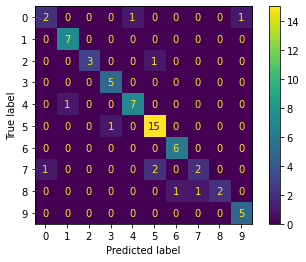

In [ ]:
cm = confusion_matrix(True_Label_Test, predictions_Test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print("Accuracy score is ",np.round(accuracy_score(True_Label_Test, predictions_Test),2))
print("F1 score is ",np.round(f1_score(True_Label_Test, predictions_Test, average='macro'),2))
print("Precision score is ",np.round(precision_score(True_Label_Test, predictions_Test, average='macro'),2))
print("Recall score is ",np.round(recall_score(True_Label_Test, predictions_Test, average='macro'),2))

Accuracy score is  0.84
F1 score is  0.8
Precision score is  0.84
Recall score is  0.8
